In [2]:
import warnings
import scanpy as sc
import anndata as an
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from urllib import request
import json
import os
from tqdm.notebook import tqdm

import statsmodels.api as sm
from statsmodels.formula.api import ols
from tqdm.notebook import tqdm
from statsmodels.stats.multitest import multipletests

sc.settings.set_figure_params(dpi=80)
#sc.set_figure_params(facecolor="white", figsize=(8, 8))
warnings.simplefilter(action='ignore', category=FutureWarning)
sc.settings.verbosity = 3

# Global variables

In [2]:
de_dir_path = '../../data/DE/ANOVA_mean/'

In [3]:
layers = ['L1', 'L2', 'L3', 'L4', 'L5', "L6", 'WM']

In [4]:
os.listdir(de_dir_path)

['anova_mamm_mean.csv',
 'cluster_spectr_anova_mean_6.csv',
 'cluster_spectr_anova_mean_7.csv',
 'cluster_spectr_anova_mean_8.csv',
 'cluster_spectr_anova_mean_9.csv',
 'ttest_mamm_mean.csv']

## Load files

### DE results

In [5]:
anova_res = pd.read_csv(de_dir_path + 'anova_mamm_mean.csv', index_col=0)
anova_genes = anova_res[anova_res.p_val_adj < 0.05].index
anova_res.head()

,sum_sq,df,F,PR(>F),p_val_adj
A1BG,0.122578,12.0,2.796490,0.003701,0.010364
AAAS,0.017527,12.0,0.944161,0.509517,0.596369
AACS,0.136394,12.0,2.729393,0.004508,0.012212
AADAT,0.057031,12.0,5.478881,0.000002,0.000016
AAGAB,0.043359,12.0,2.127609,0.026045,0.053640


In [6]:
n_clusters = 7
anova_labels = pd.read_csv(de_dir_path + f'cluster_spectr_anova_mean_{n_clusters}.csv', index_col=0)['0'].sort_values()
anova_labels = anova_labels
anova_labels.name = 'ANOVA_labels'

## Load normalized pseudobulks

In [7]:
pb_dir_path = './results/'

In [8]:
os.listdir(pb_dir_path)

['.ipynb_checkpoints',
 'ancova_res.pkl',
 'chimp_clusters_28.csv',
 'chimp_clusters_50.csv',
 'chimp_clusters_77.csv',
 'gene_selection_df.csv',
 'hs_anova_inter_clusters.csv',
 'hs_layers.csv',
 'hs_prof.csv',
 'hs_prof_anova.csv',
 'hs_ttest_inter_clusters.csv',
 'human_clusters_28.csv',
 'human_clusters_50.csv',
 'human_clusters_67.csv',
 'human_clusters_77.csv',
 'human_clusters_ancova.csv',
 'hum_spec_onehot.csv',
 'l1_distances.pkl',
 'macaque_clusters_28.csv',
 'macaque_clusters_77.csv',
 'mean_norm_clust_allgenes.csv',
 'optimal_model_res.pkl',
 'pb_mammals_samplenorm_mean_filtered.h5ad',
 'specie_specific_genes_tr28.pkl',
 'specie_specific_genes_tr35.pkl',
 'specie_specific_genes_tr50.pkl',
 'specie_specific_genes_tr67.pkl',
 'specie_specific_genes_tr77.pkl',
 'zscore_norm_clust_allgenes.csv']

In [9]:
adata_pb_norm = sc.read_h5ad(pb_dir_path + 'pb_mammals_samplenorm_mean_filtered.h5ad')
#adata_pb_norm_mean.var = anova_res
adata_pb_norm

AnnData object with n_obs × n_vars = 89 × 5390
    obs: 'layer', 'sample_id', 'psbulk_n_cells', 'psbulk_counts', 'condition', 'lib_size', 'log_lib_size'
    var: 'feature_types', 'mt', 'hb', 'ribo'
    uns: 'log1p', 'pca'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'psbulk_props'

In [10]:
background_genes = adata_pb_norm.var_names.tolist()
len(background_genes)

5390

### Create dataframe

In [11]:
df = pd.DataFrame(adata_pb_norm.X, index=adata_pb_norm.obs_names, columns=adata_pb_norm.var_names)

In [12]:
sample_order = dict()
for cond in ['human', 'chimp', 'macaque']:
    samples = df.loc[df.index.str.contains(cond)].index
    order = sorted(samples.tolist(), key=lambda x: x[-2:])
    order_laminar = list(filter(lambda x: 'L' in x, order))
    order_wm = list(filter(lambda x: 'WM' in x, order))
    sample_order[cond] = order_wm + order_laminar
sample_order['all'] = sample_order['human'] + sample_order['chimp'] + sample_order['macaque']
df = df.loc[sample_order['all']]

In [13]:
df.head()

,AACS,AAGAB,AAK1,AAMP,AAR2,AARS1,AARS2,AASDH,AASDHPPT,AATF,...,ZNFX1,ZNHIT3,ZNRD2,ZNRF1,ZPR1,ZRANB2,ZSCAN18,ZSCAN21,ZUP1,ZZZ3
human_759_WM,0.041268,0.025707,-0.072019,0.051644,-0.040637,0.007453,-0.047439,0.013681,-0.112373,-0.027305,...,0.002537,-0.145321,-0.012920,-0.019393,0.010821,0.002873,0.018861,0.032487,-0.083505,-0.040384
human_j12_WM,0.025153,-0.044543,0.001885,0.044115,-0.005605,0.064853,-0.020012,0.036537,-0.247531,0.059761,...,0.029141,-0.053724,0.029411,-0.080373,-0.068238,-0.011533,-0.072855,-0.043932,-0.005179,0.055280
human_j3_WM,-0.028083,-0.011412,0.121080,-0.036493,-0.043526,-0.017252,-0.003079,0.047993,-0.150683,0.065300,...,0.026583,-0.017077,0.022215,-0.106516,0.025459,0.008847,-0.013096,-0.029365,0.055279,0.020677
human_j4_WM,-0.020194,-0.054054,0.040012,-0.023853,0.081220,0.055494,-0.012639,-0.001961,-0.177060,0.061381,...,0.055548,-0.082023,0.017378,-0.073447,0.030231,-0.000191,-0.116543,-0.023978,0.012403,0.078987
human_j6_WM,0.004524,0.010688,0.078731,0.049893,-0.014778,-0.074468,-0.035236,-0.024390,0.091938,0.022454,...,-0.049726,-0.146974,0.022209,0.003881,0.070576,0.027428,-0.033470,-0.019749,0.130150,0.027191


### Find an optimal polinomial formula

In [14]:
df_cont = df.copy()
df_cont['condition'] = adata_pb_norm.obs.condition
df_cont['layer'] = adata_pb_norm.obs.layer
df_cont['layer'] = df_cont.layer.map(dict(zip(sorted(df_cont.layer.unique()), range(1, 8)))).astype(int)
df_cont['intercept'] = 1

In [15]:
df_cont.columns = df_cont.columns.str.replace('-', '')

In [16]:
formula_list = [
    'gene ~ layer',
    'gene ~ layer ^ 2',
    'gene ~ layer ^ 3',
    'gene ~ (layer + layer ^ 2)',
    'gene ~ (layer + layer ^ 3)',
    'gene ~ (layer + layer ^ 2 + layer ^ 3)'
]

In [17]:
model_list = []
for formula_index, formula_example in enumerate(formula_list):
    gene = 'AAR2'
    formula = formula_example.replace('gene', gene)
    subs_index = df_cont[df_cont.condition == 'human'].index
    model = ols(formula, data=df_cont, subset=subs_index).fit()
    model_list.append([formula_index, model.f_pvalue])

In [18]:
sorted(model_list, key=lambda x: x[1])

[[2, 0.06984000019428846],
 [1, 0.1479102371486196],
 [4, 0.19250078134584186],
 [0, 0.21526485312567545],
 [5, 0.3126228991121391],
 [3, 0.3191282884237611]]

In [19]:
optimal_model_dict = dict()
for specie in ['human', 'chimp', 'macaque']:
    p_val_list = []
    for gene in tqdm(df_cont.columns[:-3]):
        model_list = []
        for formula_index, formula_example in enumerate(formula_list):
            formula = formula_example.replace('gene', gene)
            subs_index = df_cont[df_cont.condition == specie].index
            model = ols(formula, data=df_cont, subset=subs_index).fit()
            model_list.append([formula_index, model.f_pvalue])
        # select the best model
        best_model = sorted(model_list, key=lambda x: x[1])[0]
        p_val_list.append(best_model)
    optimal_model_dict[specie] = pd.DataFrame(p_val_list, index=df.columns, columns=['model index', 'p-value'])

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

In [1]:
optimal_model_dict['human']

NameError: name 'optimal_model_dict' is not defined

In [21]:
import pickle

with open('results/optimal_model_res.pkl', 'wb') as f:
    pickle.dump(optimal_model_dict, f)

In [22]:
def get_formula(specie, gene):
    # make gene name as in df_cont
    gene_name = gene.replace('-', '')
    if optimal_model_dict[specie].loc[gene, 'p-value'] < 0.05:
        model_index = optimal_model_dict[specie].loc[gene, 'model index']
        return formula_list[model_index].replace('gene', gene_name)
    else:
        return f'{gene_name} ~ 1'

In [23]:
from itertools import permutations, combinations

res_dict = dict()
conditions = ['human', 'chimp', 'macaque']
#permut = list(combinations(conditions, 2))
permut = list(permutations(conditions, 2))

for ref_specie, sec_specie in permut:
    res_list = []
    #not_const_genes = results[results[ref_specie] < 0.05].index
    for gene in tqdm(df.columns):
        subs_index = df_cont[df_cont.condition.isin([ref_specie, sec_specie])].index
        df_cont_sub = df_cont.loc[subs_index].copy()
        df_cont_sub.condition = df_cont_sub.condition.astype(str)
        
        formula1 = get_formula(ref_specie, gene)
        model1 = ols(formula1, data=df_cont_sub).fit()
        
        formula2 = f'{gene} ~ condition' if formula1[-1] == '1' else f'{formula1} * condition'
        model2 = ols(formula2, data=df_cont_sub).fit()

        res_list.append(model2.compare_f_test(model1))
    res_dict[f'{ref_specie}-{sec_specie}'] = pd.DataFrame(res_list, columns=['F-score', 'p-value', 'df'], index=df.columns)

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

In [24]:
res_dict.keys()

dict_keys(['human-chimp', 'human-macaque', 'chimp-human', 'chimp-macaque', 'macaque-human', 'macaque-chimp'])

In [25]:
res_df = res_dict['human-chimp']
res_df[res_df['p-value'] < 0.05]

,F-score,p-value,df
AAK1,3.170040,0.049499,2.0
ABCC10,4.628219,0.013722,2.0
ABCC5,3.378435,0.041060,2.0
ABLIM3,3.149486,0.032116,3.0
ACHE,4.038932,0.022887,2.0
...,...,...,...
ZMAT2,3.554717,0.020034,3.0
ZMYM2,3.911086,0.025604,2.0
ZMYND8,10.124459,0.000173,2.0
ZNF608,4.444364,0.016081,2.0


In [26]:
res_df = res_dict['human-macaque']
res_df[res_df['p-value'] < 0.05]

,F-score,p-value,df
AAK1,8.817821,4.460933e-04,2.0
AATK,15.667631,1.291293e-08,4.0
ABTB1,10.818979,9.936157e-05,2.0
ACSBG1,11.825792,5.311734e-07,4.0
ACSL1,11.082060,8.201511e-05,2.0
...,...,...,...
ZMYND11,4.175666,2.013361e-02,2.0
ZMYND8,6.450877,2.926306e-03,2.0
ZNF330,3.919225,2.522646e-02,2.0
ZNF33A,3.477649,2.165949e-02,3.0


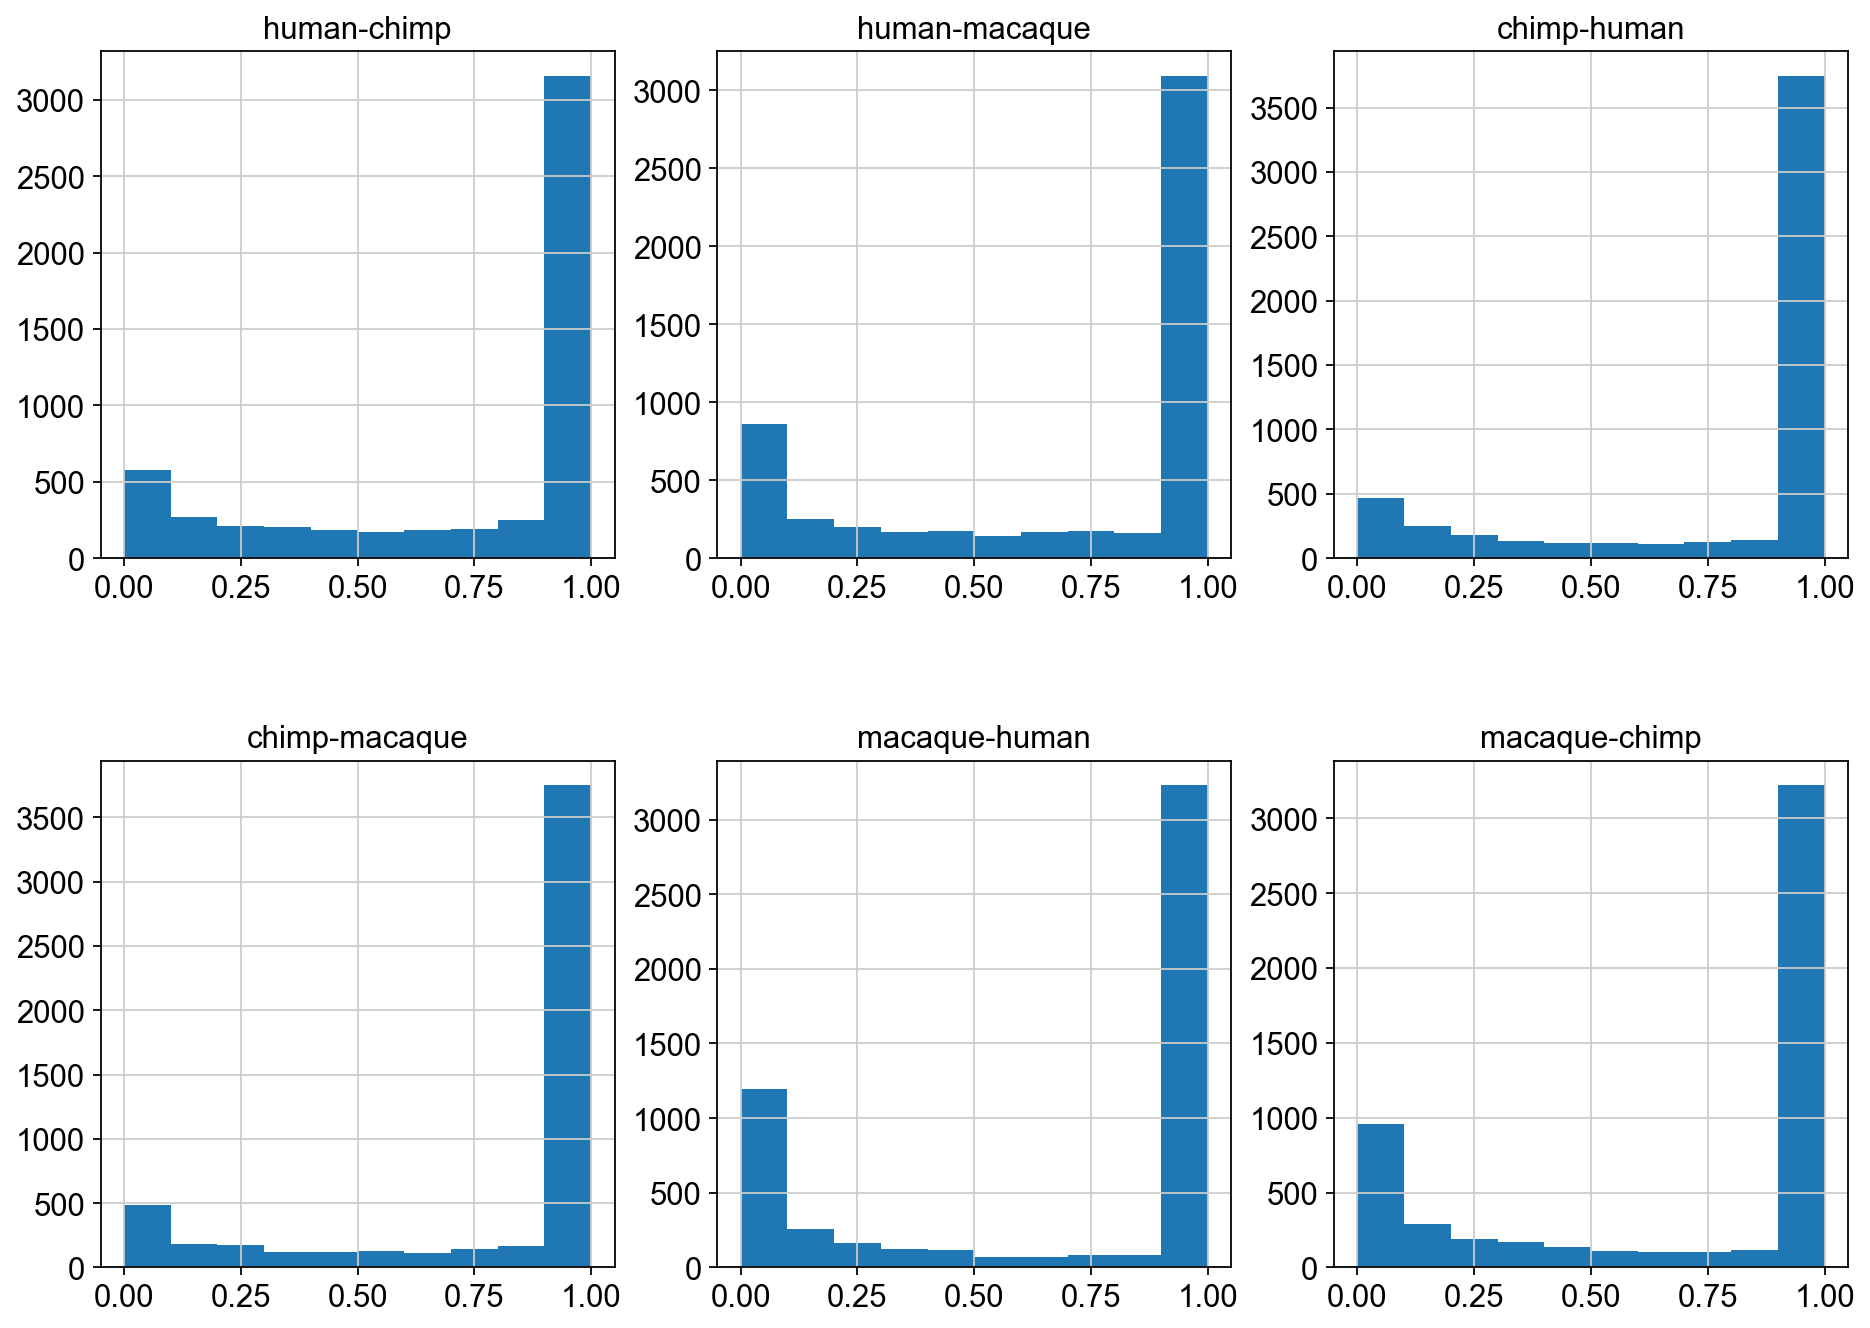

In [35]:
fig, axes = plt.subplots(2, 3,  figsize=(14, 10), gridspec_kw={'hspace': 0.4})

for (key, res_df), ax in zip(res_dict.items(), axes.flatten()):
    res_df['p-value'].hist(ax=ax)
    ax.set_title(key, fontsize=14)

In [28]:
import pickle

with open('results/ancova_res.pkl', 'wb') as f:
    pickle.dump(res_dict, f)

## Visualise

In [3]:
import pickle
with open("results/ancova_res.pkl", "rb") as file:
    ancova_results = pickle.load(file)

In [4]:
import pickle
with open("results/optimal_model_res.pkl", "rb") as file:
    optimal_model_res = pickle.load(file)

In [10]:
optimal_model_res['human']['model index'].value_counts()

model index
0    2093
5    1067
2     901
1     749
4     300
3     280
Name: count, dtype: int64

<Axes: >

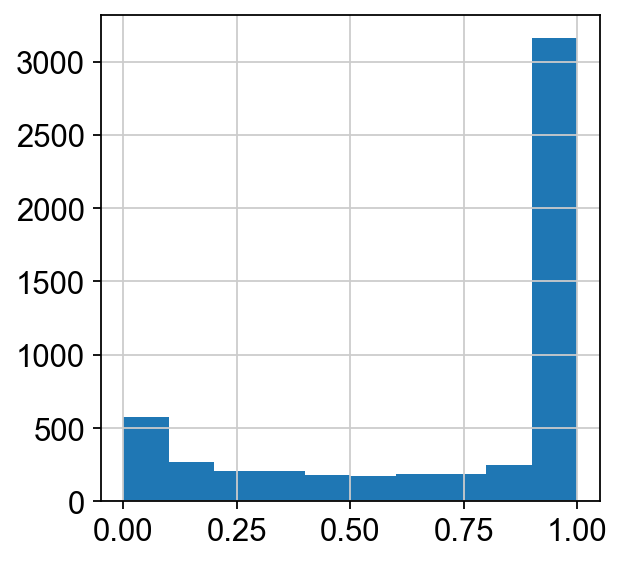

In [58]:
ancova_results['human-chimp']['p-value'].hist()

Text(0.5, 0.98, 'human-chimp')

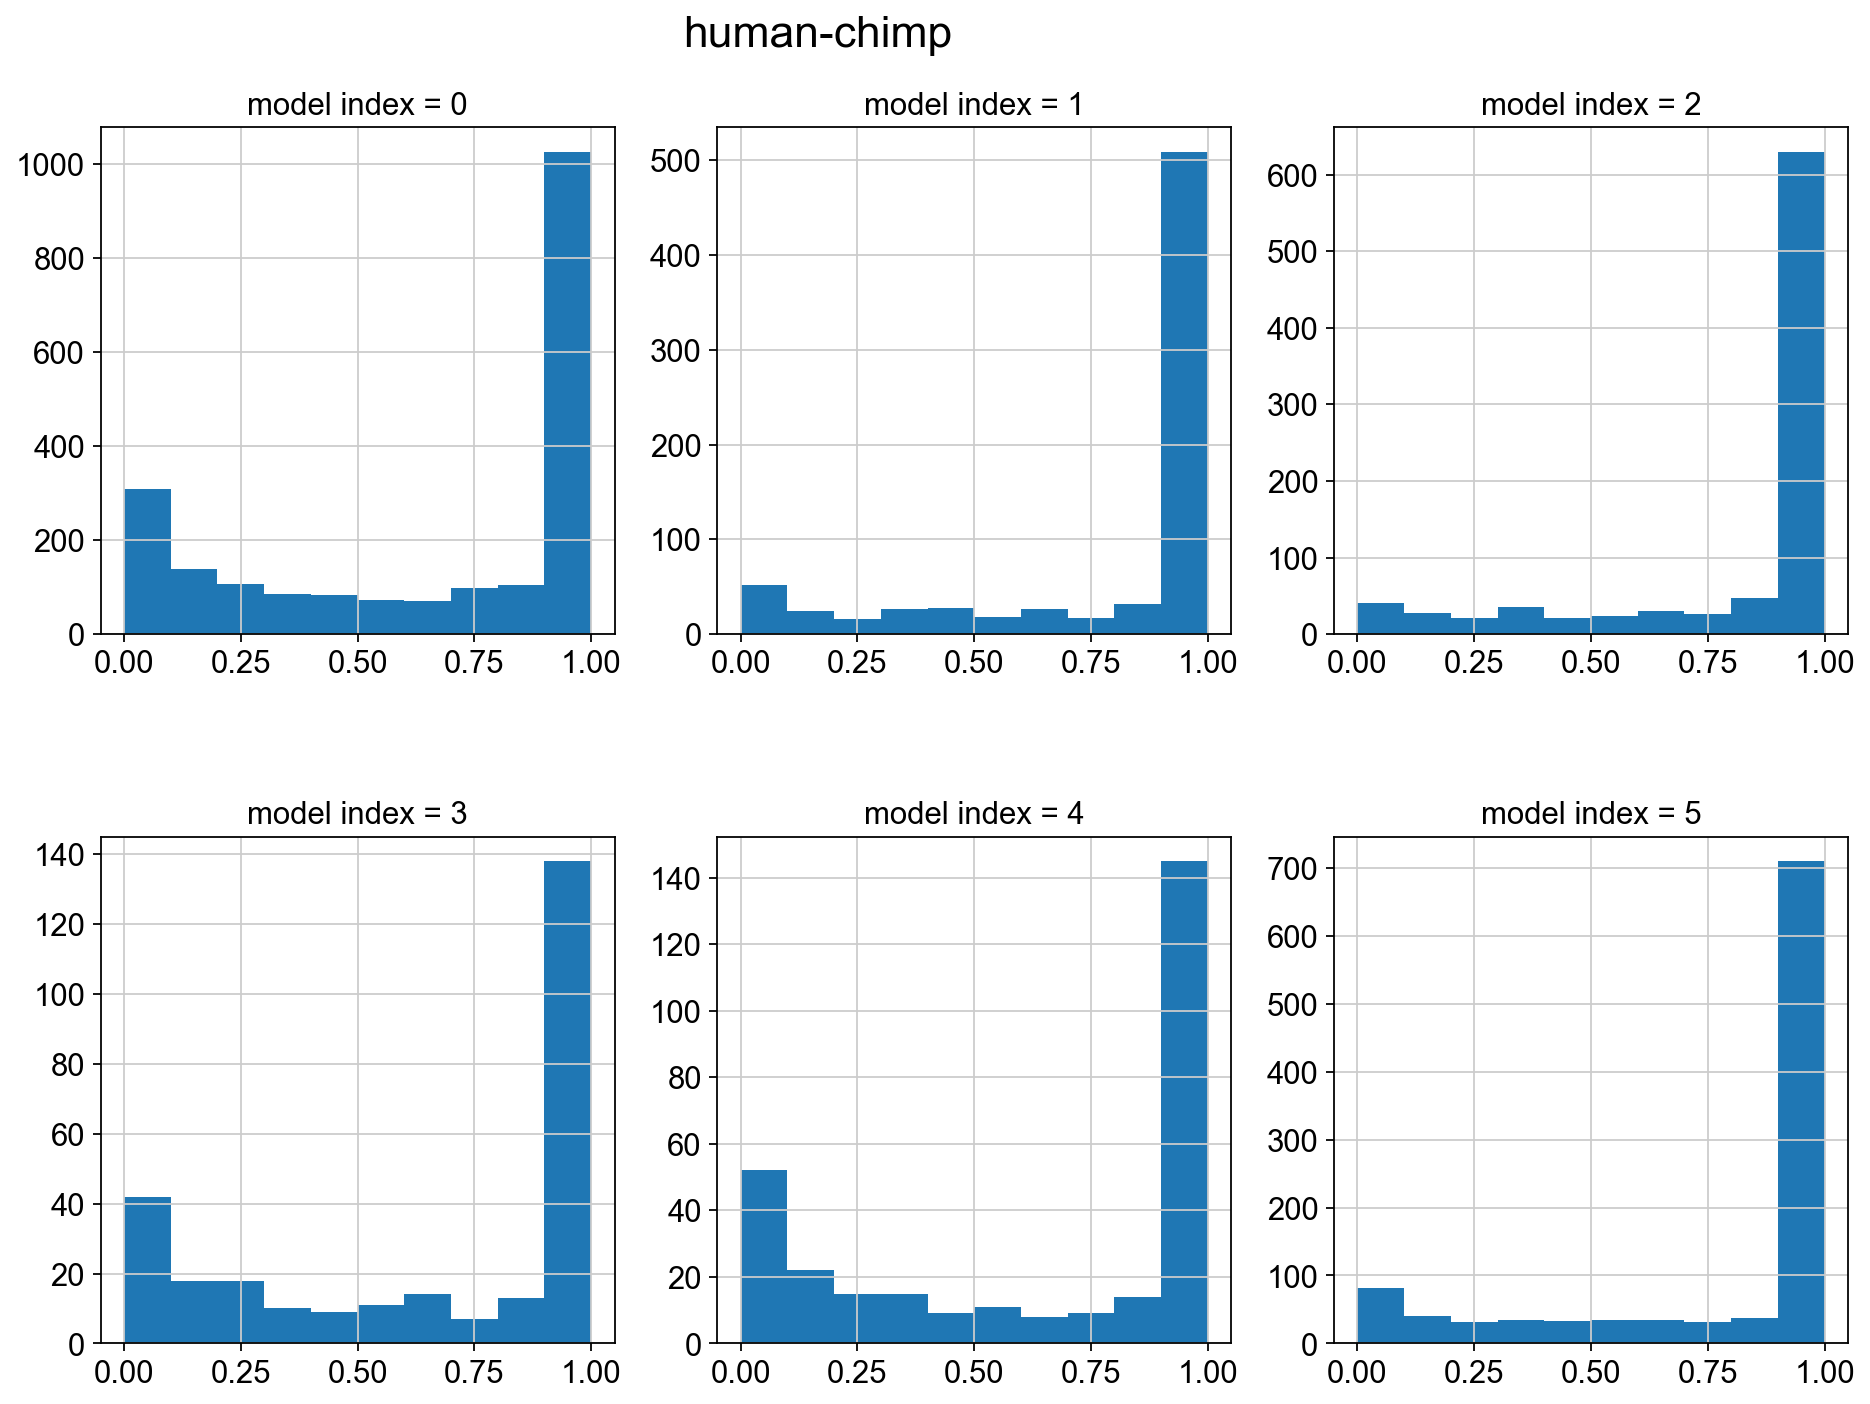

In [67]:
fig, axes = plt.subplots(2, 3,  figsize=(14, 10), gridspec_kw={'hspace': 0.4})
ancova_results['human-chimp']['model index'] = optimal_model_res['human']['model index']
res_df = ancova_results['human-chimp']
for i, ax in enumerate(axes.flatten()):
    res_df[res_df['model index'] == i]['p-value'].hist(ax=ax)
    ax.set_title(f'model index = {i}', fontsize=14)
fig.suptitle('human-chimp', fontsize=20)

Text(0.5, 0.98, 'human-macaque')

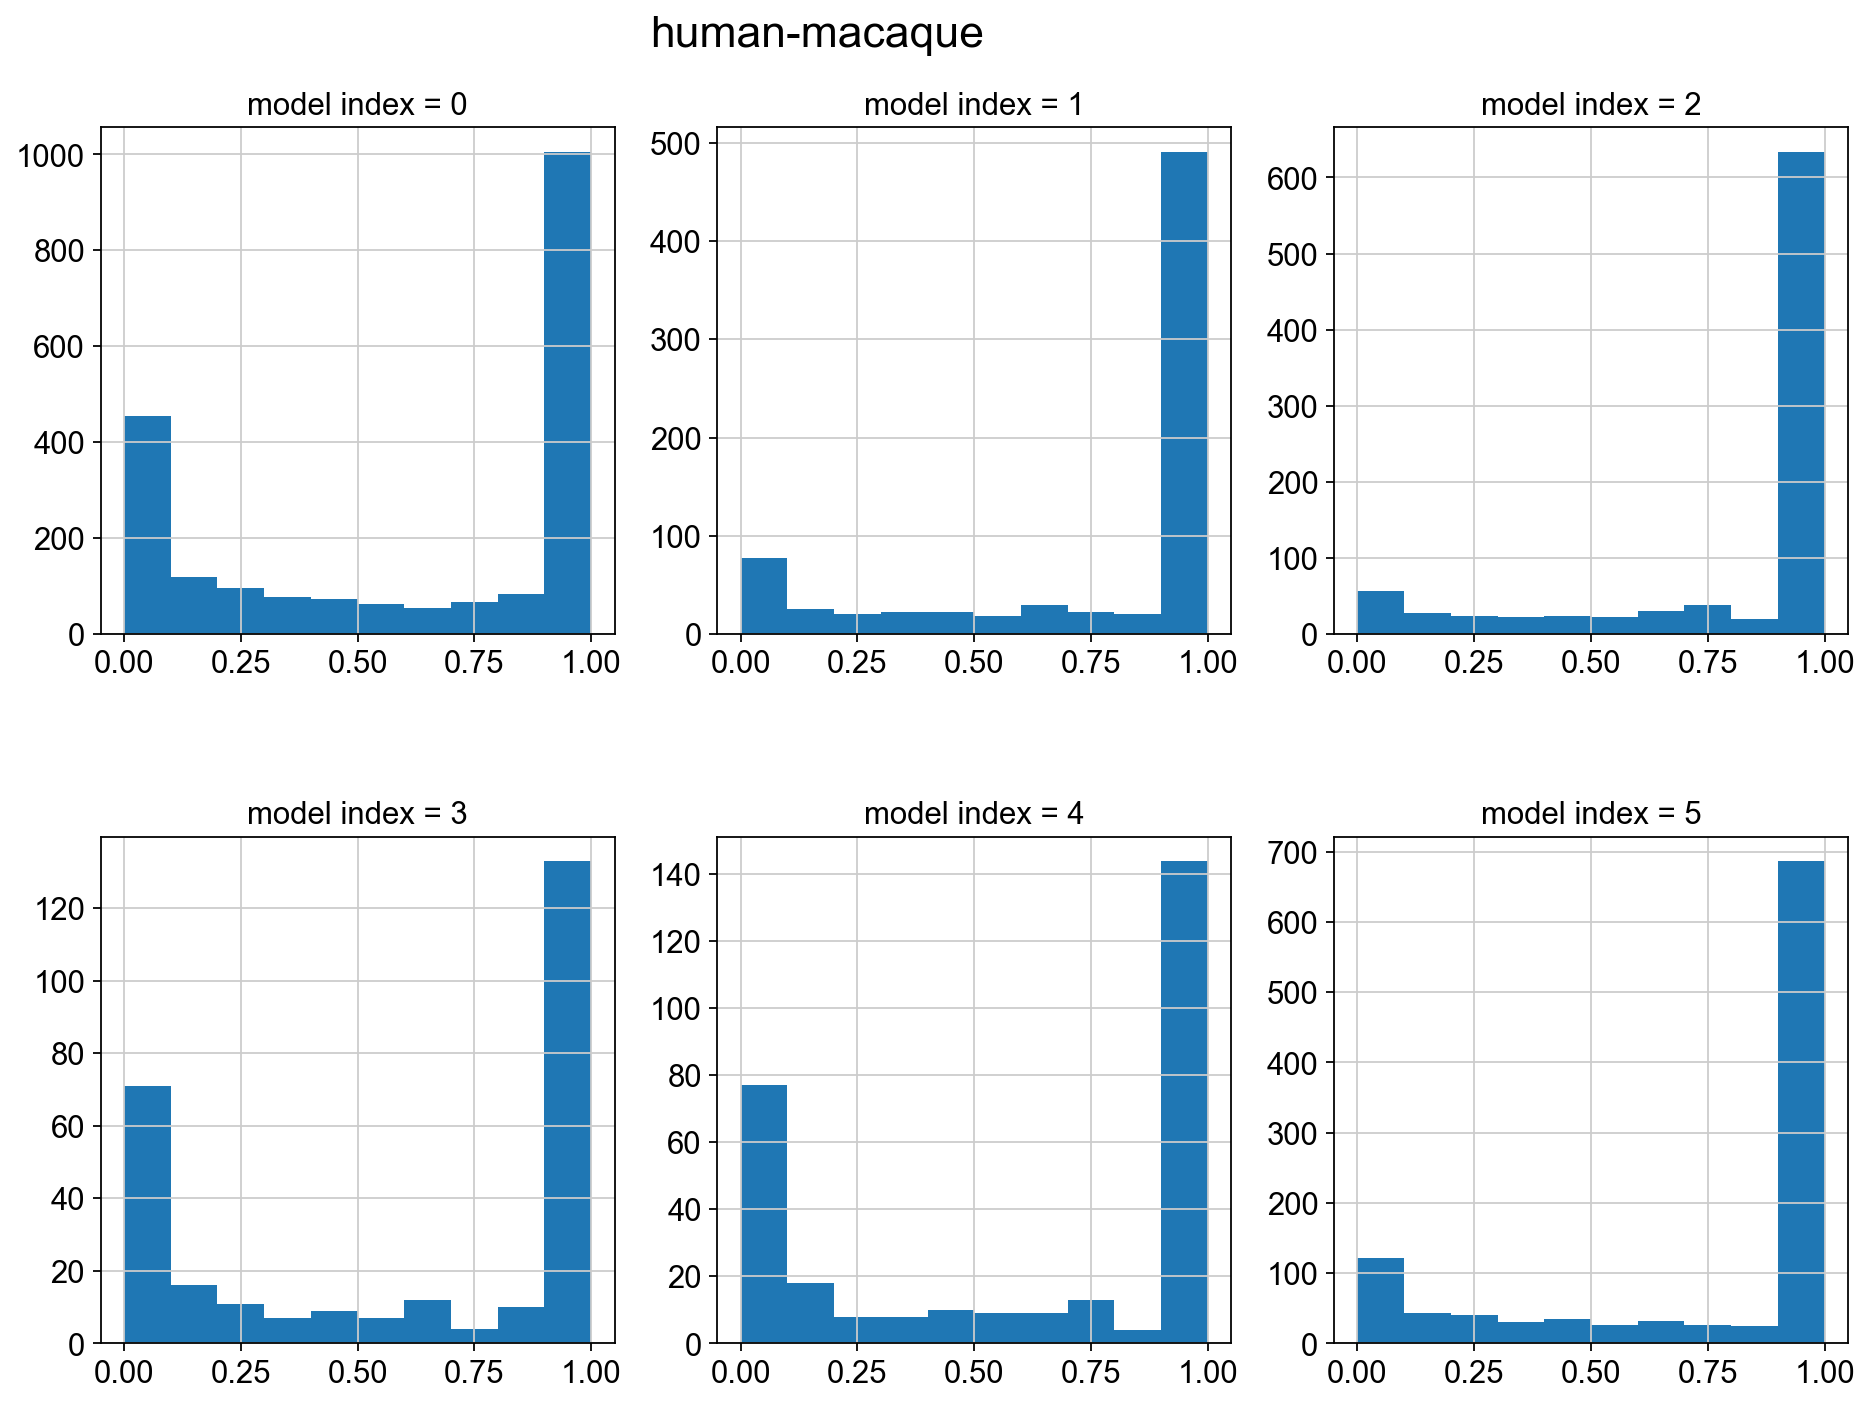

In [69]:
fig, axes = plt.subplots(2, 3,  figsize=(14, 10), gridspec_kw={'hspace': 0.4})
ancova_results['human-macaque']['model index'] = optimal_model_res['human']['model index']
res_df = ancova_results['human-macaque']
for i, ax in enumerate(axes.flatten()):
    res_df[res_df['model index'] == i]['p-value'].hist(ax=ax)
    ax.set_title(f'model index = {i}', fontsize=14)
fig.suptitle('human-macaque', fontsize=20)

Text(0.5, 0.98, 'macaque-human')

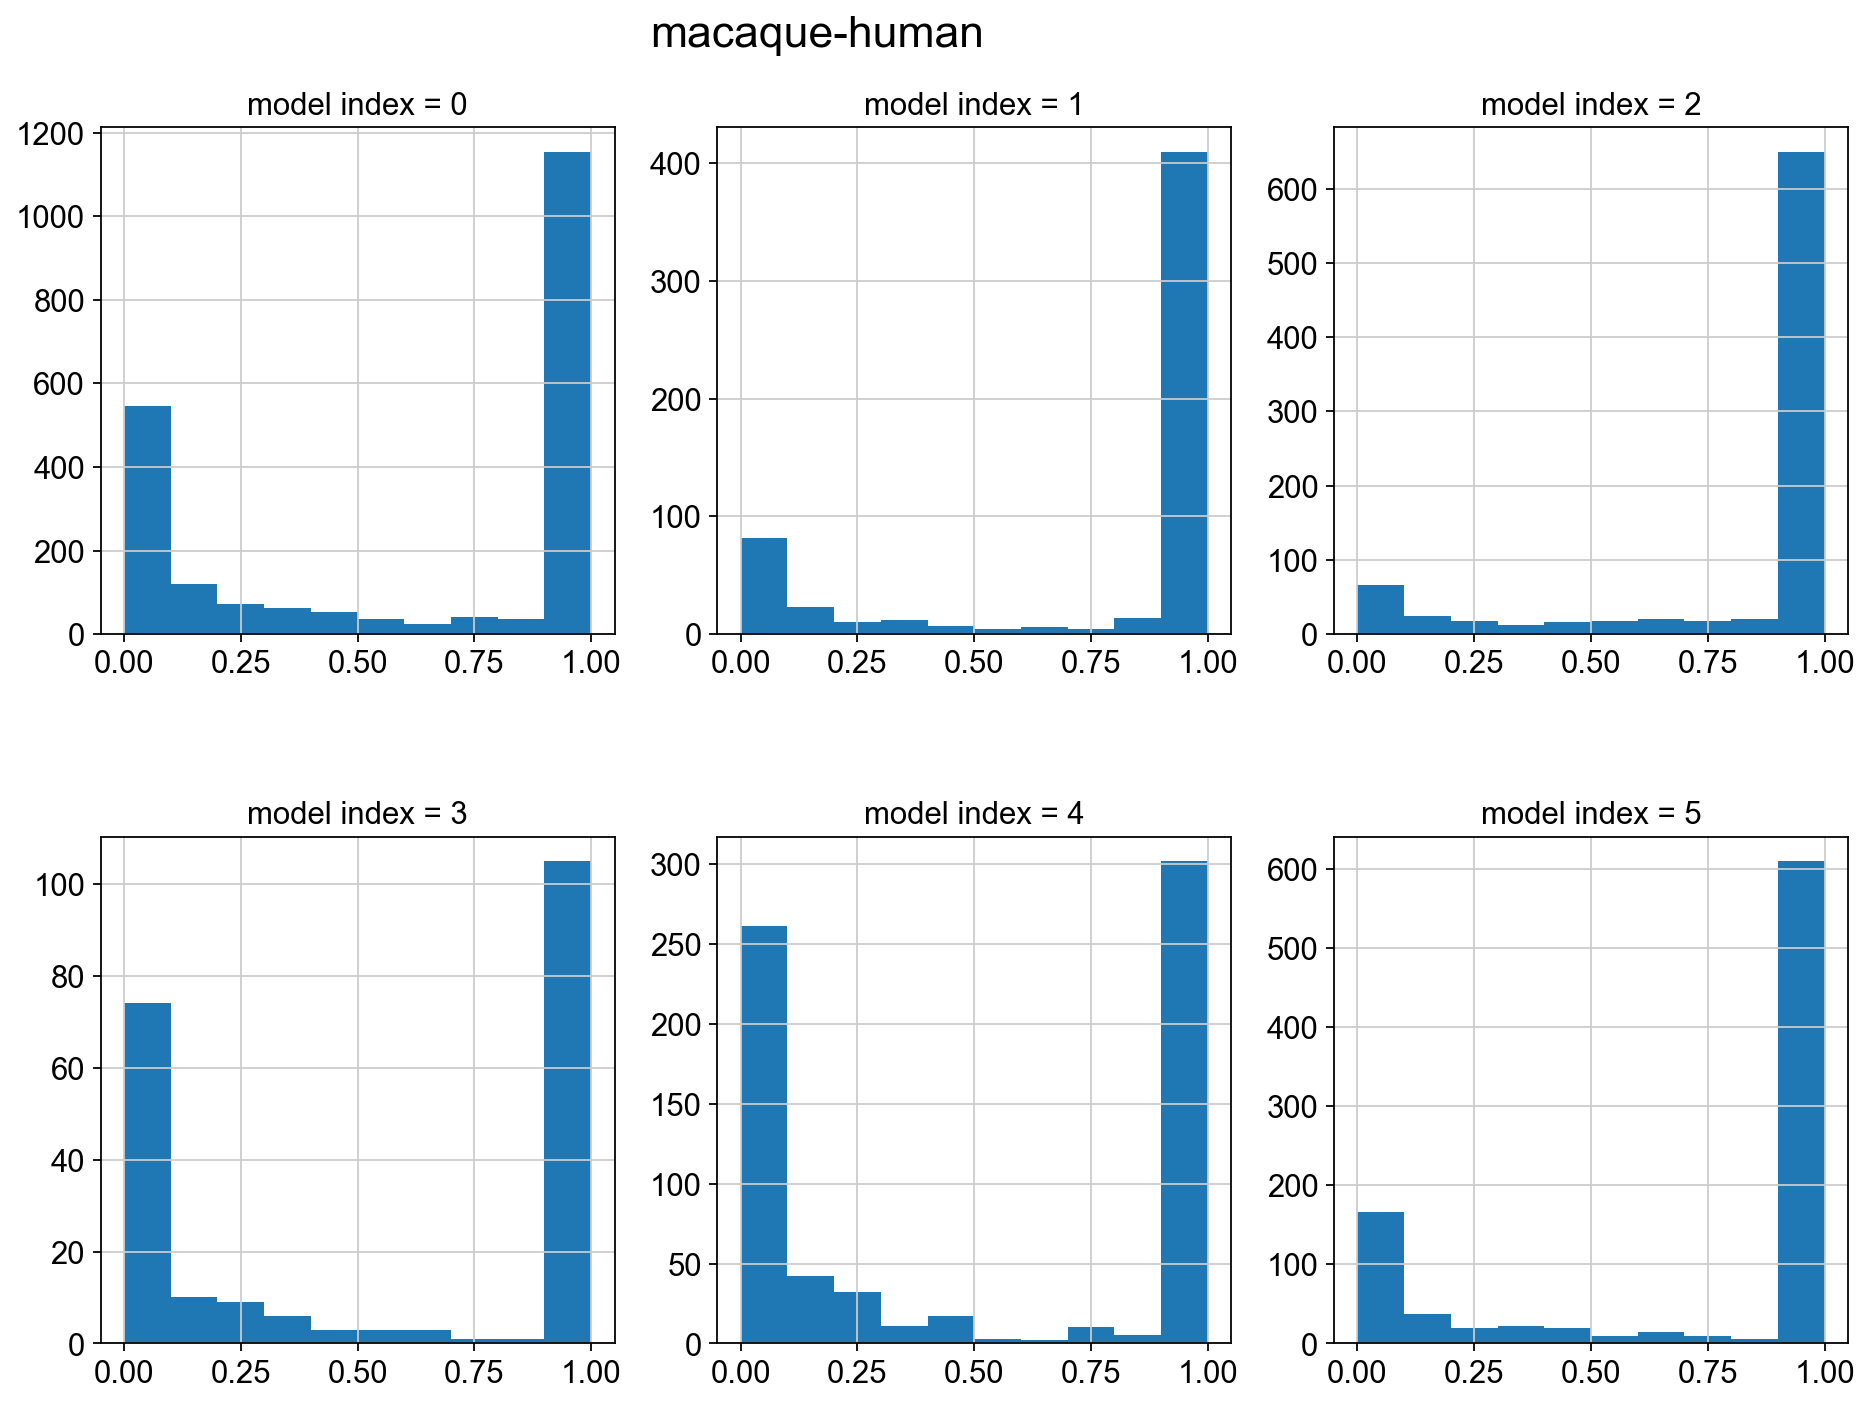

In [70]:
fig, axes = plt.subplots(2, 3,  figsize=(14, 10), gridspec_kw={'hspace': 0.4})
ancova_results['macaque-human']['model index'] = optimal_model_res['macaque']['model index']
res_df = ancova_results['macaque-human']
for i, ax in enumerate(axes.flatten()):
    res_df[res_df['model index'] == i]['p-value'].hist(ax=ax)
    ax.set_title(f'model index = {i}', fontsize=14)
fig.suptitle('macaque-human', fontsize=20)

### Number of specific genes

In [30]:
sign_genes = {key:value[value['p-value'] < 0.05].index for key, value in res_dict.items()}
sign_genes

{'human-chimp': Index(['AAK1', 'ABCC10', 'ABCC5', 'ABLIM3', 'ACHE', 'ACSL1', 'ACTN2', 'ADORA1',
        'AGFG1', 'AHI1',
        ...
        'ZBTB14', 'ZBTB17', 'ZBTB46', 'ZFP37', 'ZFPL1', 'ZMAT2', 'ZMYM2',
        'ZMYND8', 'ZNF608', 'ZNF692'],
       dtype='object', length=385),
 'human-macaque': Index(['AAK1', 'AATK', 'ABTB1', 'ACSBG1', 'ACSL1', 'ACVR1B', 'ADAM11',
        'ADGRB2', 'ADPRS', 'AFDN',
        ...
        'YARS1', 'YWHAE', 'ZBTB18', 'ZBTB46', 'ZFP90', 'ZMYND11', 'ZMYND8',
        'ZNF330', 'ZNF33A', 'ZNF827'],
       dtype='object', length=660),
 'chimp-human': Index(['ABCG4', 'ACSL1', 'ACSS2', 'ACTN2', 'ADORA1', 'AHNAK2', 'AK1', 'AK2',
        'AKAP7', 'AKT3',
        ...
        'WDR37', 'WDR45', 'WDR83', 'ZBTB17', 'ZBTB46', 'ZFAND2B', 'ZFP37',
        'ZMYND8', 'ZNF689', 'ZNF692'],
       dtype='object', length=325),
 'chimp-macaque': Index(['ABCD3', 'ACAD9', 'ACOT13', 'ACTG1', 'ACTN2', 'ADAM19', 'ADGRB1',
        'ADPGK', 'AK5', 'AKAP7',
        ...
        'WIF1',

In [31]:
hs_genes = sign_genes['human-chimp'].intersection(sign_genes['human-macaque']).difference(sign_genes['chimp-macaque'])
hs_genes, hs_genes.size

(Index(['AAK1', 'ACSL1', 'AHI1', 'AKT3', 'ALCAM', 'ANXA6', 'APBB2', 'ARHGAP12',
        'ARHGEF1', 'ASPHD2',
        ...
        'TMEM59L', 'TPD52L1', 'TSC22D1', 'USP9X', 'VAT1L', 'VGLL4', 'VPS51',
        'XPNPEP1', 'YWHAE', 'ZBTB46'],
       dtype='object', length=128),
 128)

In [32]:
cs_genes = sign_genes['chimp-macaque'].intersection(sign_genes['chimp-human']).difference(sign_genes['human-macaque'])
cs_genes, cs_genes.size

(Index(['ACTN2', 'AKAP7', 'ALKBH5', 'ANKRD29', 'AQP11', 'BMT2', 'BOLA3',
        'CBLN4', 'CDIPT', 'CEP85L', 'COA1', 'COG7', 'COX15', 'CPSF4', 'DNAJC4',
        'ECSIT', 'EML2', 'FKBP2', 'FLII', 'GIPC1', 'GNG7', 'GTPBP1', 'HCCS',
        'HSPB11', 'IDH3G', 'IGFBP2', 'KLF3', 'KLHL32', 'LCMT1', 'LDHB', 'LMO3',
        'LONP2', 'LYPD6', 'MAFG', 'MAP3K7', 'MBP', 'MCUB', 'MRPL23', 'NR2F6',
        'NT5C2', 'NUP93', 'PIK3R4', 'PIP4K2C', 'PML', 'POP5', 'PPP4R3B',
        'PQBP1', 'PTOV1', 'PTP4A2', 'RAB28', 'RARS1', 'RCAN2', 'RCHY1', 'RING1',
        'RNF2', 'SAP30BP', 'SDCBP2', 'SEMA3A', 'SETD1B', 'SETDB2', 'SLC4A1AP',
        'SMARCA1', 'SPRED2', 'STARD4', 'SULF1', 'TALDO1', 'TBPL1', 'TM2D1',
        'TMCC2', 'TMEM126B', 'TMEM259', 'TRMT61B', 'TUSC2', 'WDR37', 'WDR83',
        'ZBTB17', 'ZFAND2B'],
       dtype='object'),
 77)

In [33]:
ms_genes = sign_genes['macaque-chimp'].intersection(sign_genes['macaque-human']).difference(sign_genes['human-chimp']).difference(sign_genes['chimp-human'])
ms_genes, ms_genes.size

(Index(['AATK', 'ABAT', 'ABCD4', 'ABTB1', 'ACAD9', 'ACSBG1', 'ADAM19', 'ADGRB1',
        'AIDA', 'AKR1A1',
        ...
        'ZDHHC24', 'ZDHHC8', 'ZDHHC9', 'ZNF140', 'ZNF184', 'ZNF304', 'ZNF408',
        'ZNF48', 'ZNF576', 'ZNF606'],
       dtype='object', length=468),
 468)

# Polinoms of 3rd degree only

In [36]:
from itertools import permutations, combinations

res_dict = dict()
conditions = ['human', 'chimp', 'macaque']
permut = list(combinations(conditions, 2))
#permut = list(permutations(conditions, 2))

for ref_specie, sec_specie in permut:
    res_list = []
    #not_const_genes = results[results[ref_specie] < 0.05].index
    for gene in tqdm(df_cont.columns[:-3]):
        subs_index = df_cont[df_cont.condition.isin([ref_specie, sec_specie])].index
        df_cont_sub = df_cont.loc[subs_index].copy()
        df_cont_sub.condition = df_cont_sub.condition.astype(str)
        
        formula1 = f'{gene} ~ layer + layer ^ 2 + layer ^ 3'
        model1 = ols(formula1, data=df_cont_sub).fit()
        
        formula2 = f'{gene} ~ (layer + layer ^ 2 + layer ^ 3) * condition'
        model2 = ols(formula2, data=df_cont_sub).fit()

        res_list.append(model2.compare_f_test(model1))
    res_dict[f'{ref_specie}-{sec_specie}'] = pd.DataFrame(res_list, columns=['F-score', 'p-value', 'df'], index=df.columns)

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

  0%|          | 0/5390 [00:00<?, ?it/s]

In [37]:
res_dict.keys()

dict_keys(['human-chimp', 'human-macaque', 'chimp-macaque'])

In [38]:
import pickle

with open('results/ancova_3df_res.pkl', 'wb') as f:
    pickle.dump(res_dict, f)

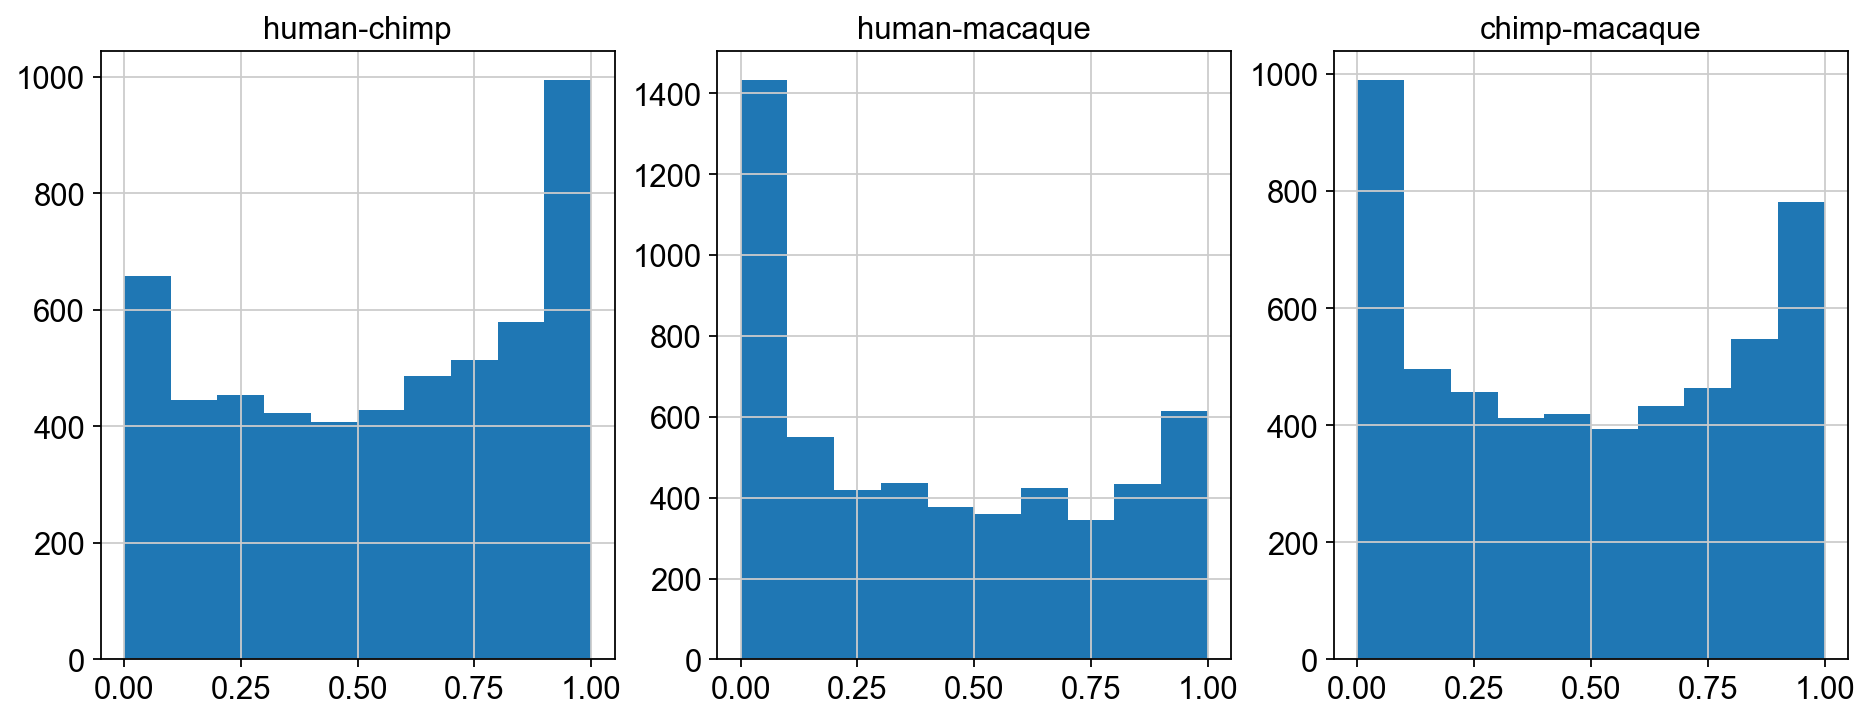

In [39]:
fig, axes = plt.subplots(1, 3,  figsize=(14, 5), gridspec_kw={'hspace': 0.4})

for (key, res_df), ax in zip(res_dict.items(), axes.flatten()):
    res_df['p-value'].hist(ax=ax)
    ax.set_title(key, fontsize=14)

## Visualise

In [40]:
import pickle
with open("results/ancova_3df_res.pkl", "rb") as file:
    ancova_results = pickle.load(file)

In [41]:
sign_genes = {key:value[value['p-value'] < 0.05].index for key, value in res_dict.items()}
sign_genes

{'human-chimp': Index(['ABCC10', 'ABCC5', 'ACBD6', 'ACSL1', 'ACTN2', 'ADORA1', 'AHNAK2', 'AK1',
        'AKAP7', 'AKT3',
        ...
        'WDR45', 'YWHAE', 'ZBTB17', 'ZBTB46', 'ZFP37', 'ZFPL1', 'ZMAT2',
        'ZMYND8', 'ZNF689', 'ZNF692'],
       dtype='object', length=400),
 'human-macaque': Index(['AAGAB', 'AAK1', 'AATF', 'AATK', 'ABAT', 'ABCC10', 'ABCD3', 'ABCD4',
        'ABTB1', 'ACAD9',
        ...
        'ZNF184', 'ZNF304', 'ZNF330', 'ZNF33A', 'ZNF408', 'ZNF575', 'ZNF576',
        'ZNF655', 'ZNF689', 'ZNF768'],
       dtype='object', length=1041),
 'chimp-macaque': Index(['AATK', 'ABAT', 'ABCD3', 'ABCD4', 'ABLIM3', 'ABTB1', 'ACAD9', 'ACOT13',
        'ACSBG1', 'ACSL1',
        ...
        'ZNF184', 'ZNF304', 'ZNF384', 'ZNF408', 'ZNF48', 'ZNF576', 'ZNF606',
        'ZNF655', 'ZNF689', 'ZNF768'],
       dtype='object', length=682)}

In [42]:
hs_genes = sign_genes['human-chimp'].intersection(sign_genes['human-macaque']).difference(sign_genes['chimp-macaque'])
hs_genes, hs_genes.size

(Index(['ABCC10', 'ADORA1', 'AHNAK2', 'AKT3', 'ALCAM', 'ANXA6', 'APBB2',
        'ARHGAP12', 'ARL1', 'ASAH1', 'ATAD1', 'ATP1A3', 'ATP5F1E', 'BBOF1',
        'CABIN1', 'CDC23', 'CDK8', 'CERS5', 'COMMD6', 'DLGAP4', 'DMAP1',
        'EIF1B', 'EIF3L', 'EIF4E3', 'EIF4G3', 'ENC1', 'ERG28', 'ETHE1',
        'FAM32A', 'FBXW11', 'FGF9', 'FOXP1', 'FYN', 'GNPTAB', 'GTF3C2',
        'IGFBP2', 'IGFBP6', 'IGSF21', 'JAM2', 'KEAP1', 'KHDRBS3', 'KIF21B',
        'KLHDC8B', 'LIN7B', 'MAU2', 'MAX', 'MRPL50', 'NANS', 'NCAM2', 'NEK4',
        'NIM1K', 'NRXN1', 'NRXN2', 'OCIAD2', 'OTUD4', 'PCBP4', 'PCDH9', 'PDIA3',
        'PEPD', 'PHYHIP', 'PPP1CB', 'PPP1CC', 'PPP2R5A', 'PPP4C', 'PSME2',
        'PTPRK', 'RAB22A', 'RABEP1', 'RALYL', 'RND2', 'RNF40', 'RRM1', 'RRP9',
        'SCN3B', 'SCRG1', 'SF3B6', 'SLC6A6', 'SMG7', 'SND1', 'SNX15', 'STAU2',
        'SURF2', 'SYNGAP1', 'SYNPR', 'THY1', 'TMEM108', 'TMEM54', 'TMEM59L',
        'TTC8', 'VAT1L', 'VGLL4', 'VIPAS39', 'VPS51', 'YWHAE', 'ZBTB46',
        'ZMYND8'

In [43]:
cs_genes = sign_genes['chimp-macaque'].intersection(sign_genes['human-chimp']).difference(sign_genes['human-macaque'])
cs_genes, cs_genes.size

(Index(['ACTN2', 'AKAP7', 'ALKBH5', 'ANAPC5', 'AQP11', 'ATG16L1', 'BMT2',
        'BOLA3', 'CDIPT', 'CTDNEP1', 'DCLK1', 'DNAJC4', 'DYNC1I2', 'ECSIT',
        'FAM76A', 'FLII', 'HCCS', 'HIKESHI', 'HSF1', 'HSPB11', 'LMO3', 'LYPD6',
        'MAFG', 'MCUB', 'MRPL23', 'MRPL49', 'MRPS36', 'MYG1', 'NUDCD1', 'NUP93',
        'PCYOX1', 'PIK3C2B', 'PIP4K2C', 'PML', 'PTOV1', 'PTP4A2', 'RAC1',
        'RCHY1', 'RING1', 'RNF2', 'RRN3', 'RSL24D1', 'SERINC1', 'SF3A2',
        'SLC4A1AP', 'STARD4', 'TIAM1', 'TMCC2', 'TMEM126B', 'TMEM130',
        'TMEM259', 'TRMT61B', 'UBTF', 'WDR37', 'ZBTB17', 'ZFPL1'],
       dtype='object'),
 56)

In [44]:
ms_genes = sign_genes['chimp-macaque'].intersection(sign_genes['human-macaque']).difference(sign_genes['human-chimp'])
ms_genes, ms_genes.size

(Index(['AATK', 'ABAT', 'ABCD3', 'ABCD4', 'ABTB1', 'ACAD9', 'ACSBG1', 'ADAM19',
        'ADGRB1', 'AIDA',
        ...
        'WSCD1', 'ZBTB7A', 'ZDHHC9', 'ZNF140', 'ZNF184', 'ZNF304', 'ZNF408',
        'ZNF576', 'ZNF655', 'ZNF768'],
       dtype='object', length=403),
 403)